# Point Processes

In [172]:
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import shapely_ext
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import shapely
import geopandas as gpd
import random


## Random Patterns

### Simulating CSR
We are going to generate several point patterns (200 events) from CSR within Virginia state boundary.

In [48]:
# open the virginia polygon shapefile
va = ps.io.open(ps.examples.get_path("virginia.shp"))
polys = [shp for shp in va]

kil = ps.io.open("polygons/kildare.shp")
kil = shapely_ext.cascaded_union(kil)

print(kil.area)
# Create the exterior polygons for VA from the union of the county shapes
state = shapely_ext.cascaded_union(polys)
print(state)

# create window from virginia state boundary
window = Window(state.parts)
window = Window(kil.parts)

print(window)

0.22996192692334144


#### 1. Generate a point series from N-conditioned CSR 

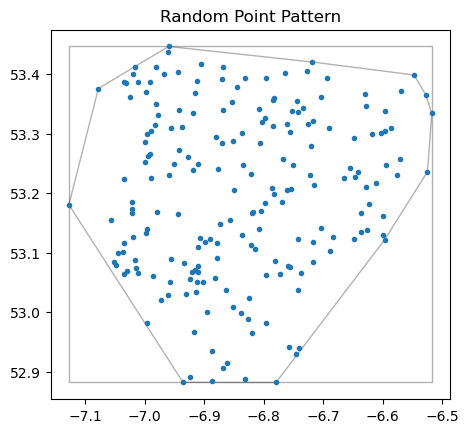

In [25]:
# simulate a csr process in the same window (200 points, 1 realization)
# by specifying "asPP" false, we can generate a point series
# by specifying "conditioning" false, we can simulate a N-conditioned CSR
np.random.seed(5)
samples = PoissonPointProcess(window, 200, 1, conditioning=False, asPP=False)

# build a point pattern from the simulated point series
pp_csr = PointPattern(samples.realizations[0])

pp_csr.n

pp_csr.plot(window=True, hull=True, title='Random Point Pattern')

#### 2. Generate a point series from $\lambda$-conditioned CSR

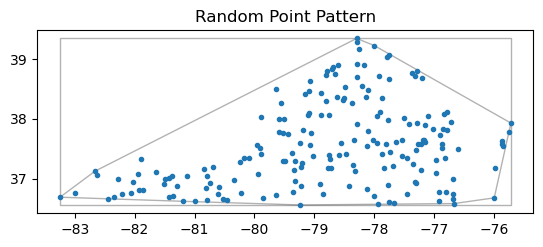

In [14]:
# simulate a csr process in the same window (200 points, 1 realization)
# by specifying "asPP" false, we can generate a point series
# by specifying "conditioning" True, we can simulate a lamda-conditioned CSR
np.random.seed(5)
samples = PoissonPointProcess(window, 200, 1, conditioning=True, asPP=False)

# build a point pattern from the simulated point series
pp_csr = PointPattern(samples.realizations[0])

pp_csr.n

pp_csr.plot(window=True, hull=True, title='Random Point Pattern')

The simulated point pattern has $194$ events rather than the Possion mean $200$.

#### 3. Generate a point pattern from N-conditioned CSR 

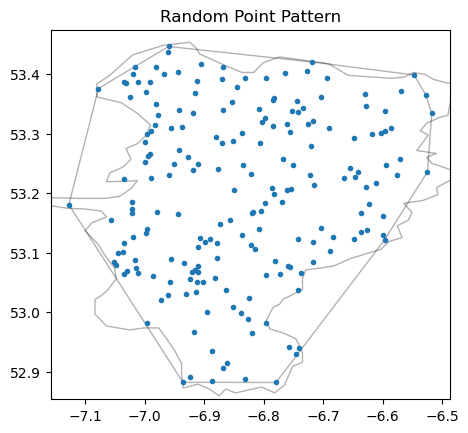

In [27]:
# simulate a csr process in the same window (200 points, 1 realization)
# by specifying "asPP" True, we can generate a point pattern
# by specifying "conditioning" false, we can simulate a N-conditioned CSR
np.random.seed(5)
samples = PoissonPointProcess(window, 200, 1, conditioning=False, asPP=True)

pp_csr = samples.realizations[0] # simulated point pattern

pp_csr.n

pp_csr.plot(window=True, hull=True, title='Random Point Pattern')

#### 4. Generate a point pattern of size 200 from a $\lambda$-conditioned CSR

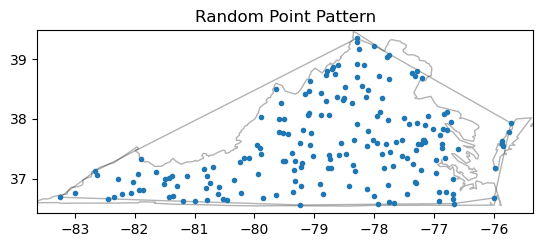

In [16]:
# simulate a csr process in the same window (200 points, 1 realization)
# by specifying "asPP" True, we can generate a point pattern
# by specifying "conditioning" True, we can simulate a lamda-conditioned CSR
np.random.seed(5)
samples = PoissonPointProcess(window, 200, 1, conditioning=True, asPP=True)

pp_csr = samples.realizations[0] # simulated point pattern

pp_csr.n

pp_csr.plot(window=True, hull=True, title='Random Point Pattern')

## Clustered Patterns

Clustered Patterns are more grouped than random patterns. Visually, we can observe more points at short distances. There are two sources of clustering:

* Contagion: presence of events at one location affects probability of events at another location (correlated point process)
* Heterogeneity: intensity $\lambda$ varies with location (heterogeneous Poisson point process)

We are going to focus on simulating correlated point process in this notebook. One example of correlated point process is Poisson cluster process. Two stages are involved in simulating a Poisson cluster process. First, parent events are simulted from a $\lambda$-conditioned or $N$-conditioned CSR. Second, $n$ offspring events for each parent event are simulated within a circle of radius $r$ centered on the parent. Offspring events are independently and identically distributed.

#### 1. Simulate a Poisson cluster process of size 200 with 10 parents and 20 children within 0.5 units of each parent (parent events:  $N$-conditioned CSR)

<Axes: >

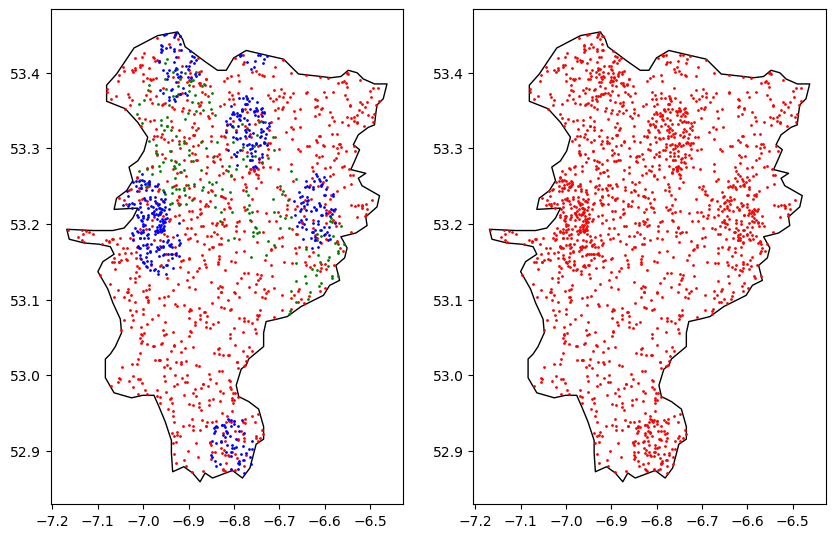

In [163]:
#np.random.seed(5)
samples = PoissonPointProcess(window, 1000, 1, conditioning=False, asPP=True)
csr_points = samples.realizations[0]

csamples_a = PoissonClusterPointProcess(window, 500, 5, 0.1, 1, asPP=True, conditioning=True)
cluster_points_a = csamples_a.realizations[0]

csamples_b = PoissonClusterPointProcess(window, 500, 5, 0.05, 1, asPP=True, conditioning=True)
cluster_points_b = csamples_b.realizations[0]


csr_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(csr_points.points['x'], csr_points.points['y']), crs=4326) 
cluster_a_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(cluster_points_a.points['x'], cluster_points_a.points['y']), crs=4326)
cluster_b_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(cluster_points_b.points['x'], cluster_points_b.points['y']), crs=4326)

kil_gdf = gpd.GeoSeries(kil)

fig, ax = plt.subplots(1,2, figsize=(10,8))

kil_gdf.plot(ax=ax[0], edgecolor='black', facecolor='none')
csr_gdf.plot(ax=ax[0], markersize=1, color='red')
cluster_a_gdf.plot(ax=ax[0], markersize=1, color='green')
cluster_b_gdf.plot(ax=ax[0], markersize=1, color='blue')


kil_gdf.plot(ax=ax[1], edgecolor='black', facecolor='none')
csr_gdf.plot(ax=ax[1], markersize=1, color='red')
cluster_a_gdf.plot(ax=ax[1], markersize=1, color='red')
cluster_b_gdf.plot(ax=ax[1], markersize=1, color='red')

#pp_pcp.plot(window=True, hull=True, title='Clustered Point Pattern') #plot the first realization

It is obvious that there are several clusters in the above point pattern.

#### 2. Simulate a Poisson cluster process of size 200 with 10 parents and 20 children within 0.5 units of each parent (parent events:  $\lambda$-conditioned CSR)

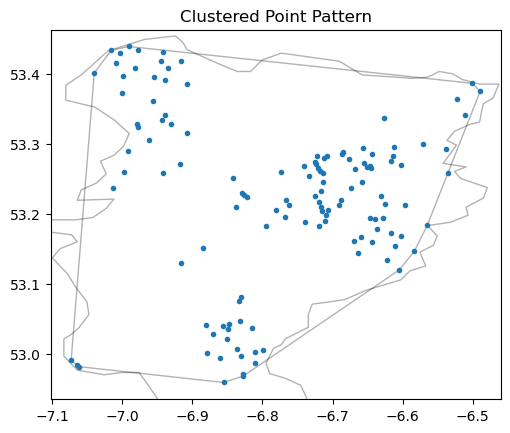

In [40]:
import numpy as np
np.random.seed(10)
csamples = PoissonClusterPointProcess(window, 100, 10, 0.05, 1, asPP=True, conditioning=True)
pp_pcp = csamples.realizations[0]
pp_pcp.plot(window=True, hull=True, title='Clustered Point Pattern')

#### 3. Simulate a Poisson cluster process of size 200 with 5 parents and 40 children within 0.5 units of each parent (parent events:  $N$-conditioned CSR)

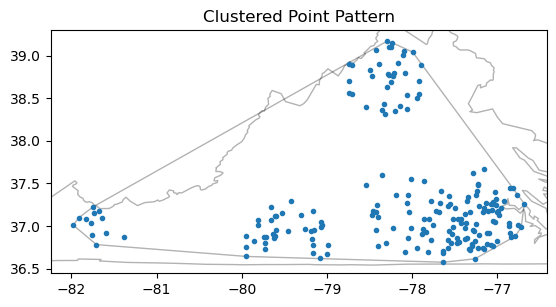

In [20]:
np.random.seed(10)
csamples = PoissonClusterPointProcess(window, 200, 5, 0.5, 1, asPP=True)
pp_pcp = csamples.realizations[0]
pp_pcp.plot(window=True, hull=True, title='Clustered Point Pattern')

[<LINESTRING (0.604 0.247, 0.343 0.373)>, <LINESTRING (0.343 0.373, 0.052 0.751)>, <LINESTRING (0.052 0.751, 0.604 0.247)>]
New edges intersect with abc, new polygon not valid.
New edges intersect with abc, new polygon not valid.
New edges intersect with abc, new polygon not valid.


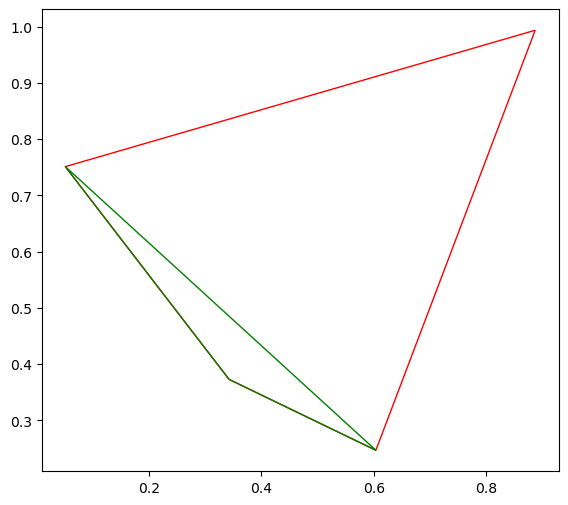

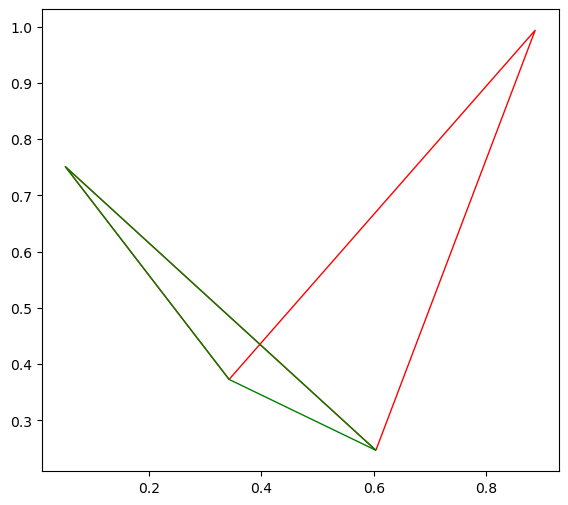

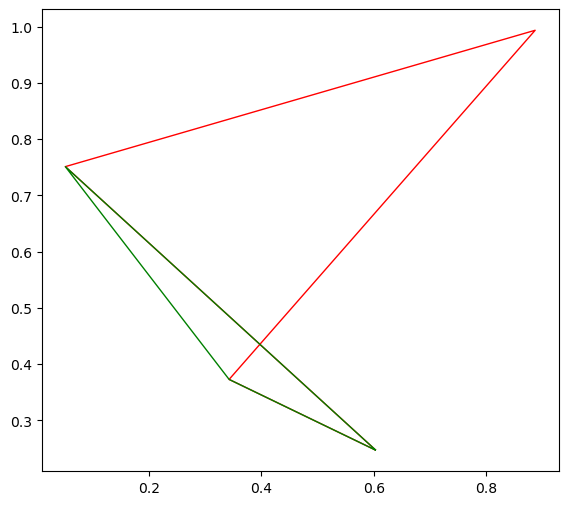

In [294]:
from shapely import Point, LineString, Polygon

bounding_box = gpd.GeoSeries(shapely.Polygon([(0,0), (0,1), (1,1),(1,0),(0,0)]))
d_min = 1e-2
minx, miny, maxx, maxy = bounding_box.total_bounds


a = Point([random.uniform(minx, maxx), random.uniform(miny, maxy)])
b = Point([random.uniform(minx, maxx), random.uniform(miny, maxy)])

ab = LineString([a,b])

c = Point([random.uniform(minx, maxx), random.uniform(miny, maxy)])

# Step 1
if(ab.distance(c) > 1e-2):  # True
    abc = Polygon([a,b,c])

# Step 2
found = False
while(not found):
    d = Point([random.uniform(minx, maxx), random.uniform(miny, maxy)])
    if d.distance(abc) > d_min:
        found = True

# Step 3
verts = list(abc.exterior.coords)[:-1]        

def get_edges(poly):
    b = poly.boundary.coords
    edges = [LineString(b[k:k+2]) for k in range(len(b) - 1)]
    return edges

print(get_edges(abc))

for i, x in enumerate(verts):
    verts_temp = verts.copy()
    verts_temp.insert(i,d.coords[0])
    s = set(get_edges(Polygon(verts_temp)))
    edge_new = [x for x in get_edges(abc) if x not in s]
    
    intersect = False
    for edge in edge_new:
        if edge.intersects(abc):
            intersect = True

    poly_new = Polygon(verts_temp)
    
    if not intersect:
        print("No intersection, new edges are valid.")
    else:
        print("New edges intersect with abc, new polygon not valid.")

    fig, ax = plt.subplots(1,1,figsize=(8,6))
    gpd.GeoSeries(poly_new).plot(ax=ax,edgecolor='red', facecolor='none')
    gpd.GeoSeries(abc).plot(ax=ax, edgecolor='green', facecolor='none')


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

bounding_box.plot(ax=ax, edgecolor='blue', facecolor='none')

gpd.GeoSeries(ab).plot(ax=ax)
gpd.GeoSeries(c).plot(ax=ax, color='red')
gpd.GeoSeries(abc).plot(ax=ax, edgecolor='green', facecolor='none')
gpd.GeoSeries(d).plot(ax=ax, color='purple')